In [2]:
# pip install git+https://github.com/Fuminides/ex-fuzzy.git
import pandas as pd
import numpy as np
import sys
# In case you run this without installing the package, you need to add the path to the package
# This is for launching from root folder path
sys.path.append('./ex_fuzzy/')
sys.path.append('./ex_fuzzy/ex_fuzzy/')
# This is for launching from Demos folder
sys.path.append('../ex_fuzzy/')
sys.path.append('../ex_fuzzy/ex_fuzzy/')

In [3]:
import ex_fuzzy.fuzzy_sets as fs
import ex_fuzzy.evolutionary_fit as GA
import ex_fuzzy.utils as  utils
import ex_fuzzy.eval_tools as eval_tools
import ex_fuzzy.pattern_stability as pattern_stability

from sklearn import datasets
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('./paygap data/pay_gap.csv')
df.head()

,JobTitle,Gender,Age,PerfEval,Education,Dept,Seniority,BasePay,Bonus
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938
1,Software Engineer,Male,21,5,College,Management,5,108476,11128
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319


In [5]:
X = df.drop(columns=['Gender'])
y = df['Gender']

In [6]:
y

0      Female
1        Male
2      Female
3        Male
4        Male
        ...  
995    Female
996      Male
997      Male
998      Male
999      Male
Name: Gender, Length: 1000, dtype: object

In [7]:
print(X.nunique())

JobTitle      10
Age           48
PerfEval       5
Education      4
Dept           5
Seniority      5
BasePay      992
Bonus        941
dtype: int64


In [8]:
fz_type_studied = fs.FUZZY_SETS.t1  # T1 fuzzy sets
n_linguistic_variables = 3  # Define the number of linguistic variables
n_gen = 30
n_pop = 30
n_rules = 20
categorical_mask = np.zeros(X.shape[1], dtype=int)
for i, column in enumerate(X.columns):
    if X[column].dtype == 'object':
        _, unique_classes = pd.factorize(X[column])
        categorical_mask[i] = len(unique_classes)
        print(f"Column '{column}' unique classes: {unique_classes.tolist()}")


precomputed_partitions = utils.construct_partitions(X, fz_type_studied, n_partitions=n_linguistic_variables, categorical_mask=categorical_mask)

Column 'JobTitle' unique classes: ['Graphic Designer', 'Software Engineer', 'Warehouse Associate', 'IT', 'Sales Associate', 'Driver', 'Financial Analyst', 'Marketing Associate', 'Data Scientist', 'Manager']
Column 'Education' unique classes: ['College', 'PhD', 'Masters', 'High School']
Column 'Dept' unique classes: ['Operations', 'Management', 'Administration', 'Sales', 'Engineering']


In [9]:
categorical_mask

array([10,  0,  0,  4,  5,  0,  0,  0])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
# Train the fuzzy rules classifier
fl_classifier = GA.BaseFuzzyRulesClassifier(nRules=n_rules, 
                                           nAnts=3,
                                           fuzzy_type=fz_type_studied,
                                           tolerance=0.01,
                                           class_names= ['Male','Female'],
                                           n_linguistic_variables=n_linguistic_variables,
                                           verbose = False,
                                           linguistic_variables=None,
                                           #linguistic_variables=precomputed_partitions,
                                           categorical_mask = categorical_mask,
                                           #runner=1, 
                                           #ds_mode=1,
                                           #allow_unknown=True,
                                           #fuzzy_modifiers=False
                                            )

fl_classifier.fit(X_train, y_train, n_gen=n_gen, pop_size=n_pop)

rule_base = fl_classifier.get_rulebase()
fl_evaluator = eval_tools.FuzzyEvaluator(fl_classifier)
str_rules = fl_evaluator.eval_fuzzy_model(X_train, y_train, X_test, y_test, 
                        plot_rules=False, print_rules=True, plot_partitions=False, return_rules=False)

------------
ACCURACY
Train performance: 0.6014925373134329
Test performance: 0.5909090909090909
------------
MATTHEW CORRCOEF
Train performance: 0.2736390665135192
Test performance: 0.22432762702961548
------------
Rules for consequent: Male
----------------
IF Age IS Medium AND PerfEval IS Low WITH DS 0.012131946286470446, ACC 0.5795246800731262
IF Education IS High School AND Dept IS Administration WITH DS 0.011862330140343063, ACC 0.5357142857142857
IF PerfEval IS High AND Education IS College WITH DS 0.014234796168411673, ACC 0.4864864864864865

Rules for consequent: Female
----------------
IF JobTitle IS Marketing Associate AND Age IS Medium WITH DS 0.02078209834149114, ACC 0.9137931034482759




Test Accuracy: 0.7455


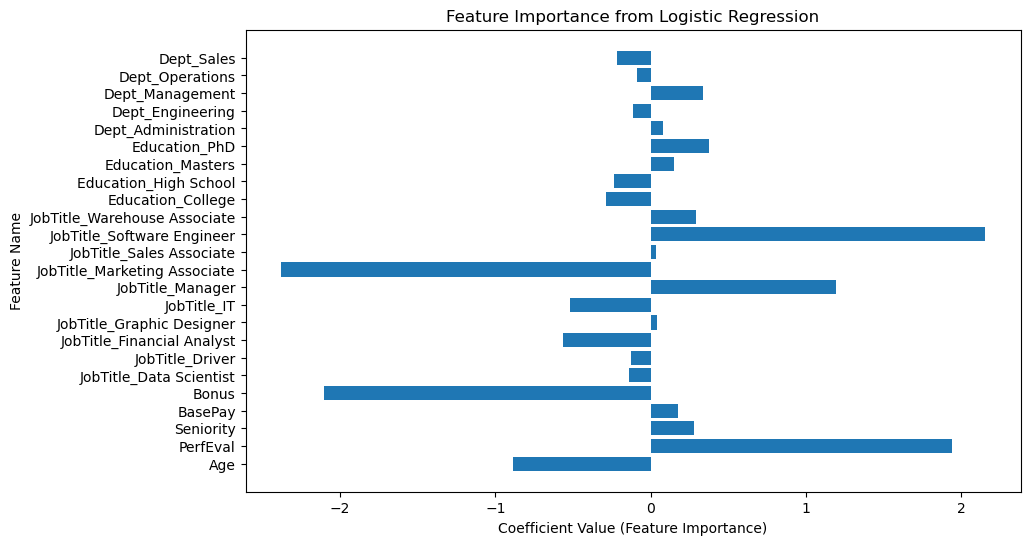

In [12]:
# LOGISTIC REGRESSION #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Step 1: Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Step 2: Create a ColumnTransformer to preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Standardize numerical features
        ('cat', OneHotEncoder(), categorical_cols)  # One-hot encode categorical features
    ])

# Step 3: Create a pipeline with preprocessing and logistic regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Step 5: Train the model
model.fit(X_train, y_train)

# Step 1: Predict on the test set
y_pred = model.predict(X_test)

# Step 2: Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Step 3: Print test accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")

# Step 6: Extract feature importance
# Get the coefficients from the logistic regression model
logistic_regression_coefs = model.named_steps['classifier'].coef_[0]

# Get the feature names after one-hot encoding
one_hot_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numerical_cols, one_hot_feature_names])

# Step 7: Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(all_feature_names, logistic_regression_coefs)
plt.xlabel('Coefficient Value (Feature Importance)')
plt.ylabel('Feature Name')
plt.title('Feature Importance from Logistic Regression')
plt.show()

c:\Users\javi-\anaconda3\envs\maps\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Test Accuracy: 0.6200


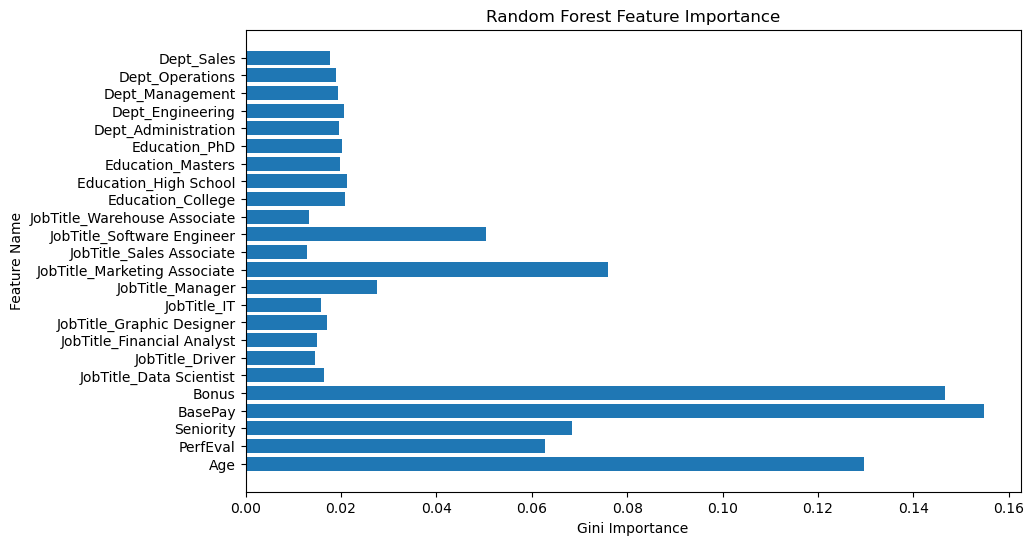

In [13]:
# RANDOM FOREST (Without Pipeline)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

# Step 1: Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Step 2: Preprocess Data Manually (No Pipeline)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# Transform categorical features
X_categorical = encoder.fit_transform(X[categorical_cols])
X_numerical = scaler.fit_transform(X[numerical_cols])

# Get feature names after transformation
one_hot_feature_names = encoder.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numerical_cols, one_hot_feature_names])

# Combine processed features
X_processed = np.hstack((X_numerical, X_categorical))

# Convert to DataFrame for consistency
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed_df, y, test_size=0.2, random_state=42)

# Step 4: Train Random Forest Model
clf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Step 5: Evaluate Model
y_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Step 6: Feature Importance (Gini Importance)
feature_importances = clf.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(all_feature_names, feature_importances)
plt.xlabel('Gini Importance')
plt.ylabel('Feature Name')
plt.title('Random Forest Feature Importance')
plt.show()